# The Problem
Our overall goal is to build classifier models to predict price_gt_1M using the the other variables. You must use sklearn Pipelines that contain your preprocessing steps and your model estimation step. We did this in the class notes.

You should do your work in a Jupyter Notebook.

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import sweetviz

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import subprocess

In [13]:
%matplotlib inline

## Task 3 - EDA

I suggest you start by reading the csv file into a pandas dataframe. I called my dataframe, `housing_df`.
Then start with some basic EDA. You can certainly use automated tools such as pandas-profiling, skimpy or SweetViz as I showed in the class notes. Remember, when you run some of those tools, you **must** have your notebook open in the classic Jupyter Notebook interface (and **NOT** in Jupyter Lab) Check their docs to see if Jupyter Lab is supported yet. I pip installed SweetViz and it seems to be working fine now with Jupyter Lab. As we've seen, the reports get created as HTML documents. These should go in your output folder within your project.

In [16]:
housing_df = pd.read_csv('data/kc_house_data_classification.csv')
housing_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_gt_1M
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,0
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,0
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,0
21609,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,0
21610,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,0
21611,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,0


In [17]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21613 non-null  int64  
 1   bathrooms      21613 non-null  float64
 2   sqft_living    21613 non-null  int64  
 3   sqft_lot       21613 non-null  int64  
 4   floors         21613 non-null  float64
 5   waterfront     21613 non-null  int64  
 6   view           21613 non-null  int64  
 7   condition      21613 non-null  int64  
 8   grade          21613 non-null  int64  
 9   sqft_above     21613 non-null  int64  
 10  sqft_basement  21613 non-null  int64  
 11  yr_built       21613 non-null  int64  
 12  yr_renovated   21613 non-null  int64  
 13  zipcode        21613 non-null  int64  
 14  lat            21613 non-null  float64
 15  long           21613 non-null  float64
 16  sqft_living15  21613 non-null  int64  
 17  sqft_lot15     21613 non-null  int64  
 18  price_

Now let's look at some automated EDA with the SweetViz package

In [18]:
report = sweetviz.analyze(housing_df)
report.show_html("../output/sweetviz_report.html")

                                             |                                                                …

FileNotFoundError: [Errno 2] No such file or directory: '../output/sweetviz_report.html'

To resolve the issues with the sweetviz package, I had to install ipywidgets. It still was showing a "Error displaying widget: model not found." According to this [Kaggle post](https://www.kaggle.com/product-feedback/264276), the magic solution is to just restart the jupyter lab session. That fixed my problem.

The SweetViz output provides additional insights. There are significantly fewer houses before 1950, which makes sense due to building decay. However, there is a surprising dip in construction between 1980 and 1990. Only 5% of houses have recorded renovations. The zero insertions may make this variable problematic. 

The results revealed additional categorical variables. A full list is below:
* Waterfront
* View
* Condition
* Zip Code
* Target Variables: Price over 1M

According to the SweetViz output, only 7% of the houses in the data have a price greater than $1 million. The associations table shows square footage, square footage above ground, grade, bathrooms, and bedrooms have the strongest association with the target variables. Some of these features clearly have multicollinearity issues that we will need to watch for when modeling.

These are just some of the interesting and important insights. The [SweetViz output file](../output/sweetviz_report.html) can provide additional detail.

## Task 4 - Categorize feature types

As we did in the Pump it Up class notes, we are going to need to create a list of categorical variables and a list of numeric variables so that we
can apply the appropriate pre-processing to each. In the notes we used the data type of the columns to create lists of numeric and categorical variables. That's not necessarily going to work here as all the variables will come in as numeric. So, you'll have to come up with another way to create lists of the categorical variables and the numeric variables. 

Since we are using regularization, all of the numeric variables will need to rescaled using the `StandardScaler`. You'll do this later as part of the `Pipeline`. For any variables that you decide should be treated as categorical in your models, use the `OneHotEncoder` on them in the preprocessing stage.

Be careful, just because a variable has a numeric datatype in the pandas dataframe, it does **not** mean that it's necessarily a numeric variable in the context of the classification models. Think about each column and look at your EDA reports and decide whether or not it's truly numeric or needs to be treated as categorical data in the models.  

Even though our target variable, `price_gt_1M`, is categorical, you do **NOT** need to do any preprocessing on it. As I mentioned in our class notes, scikit-learn will automatically detect that and will do any encoding needed on its own.

Finally, you'll partition the dataset into training and test datasets for modeling: 

* I broke up the `housing_df` into two separate dataframes that I called `X` and `y`, to use in the models. Here's my code for that:

```
X = housing_df.iloc[:, 0:18]
y = housing_df.iloc[:, 18]
```

* Please use the following code for your data partitioning so that we all end up with the same training and test split:

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)
```

In [19]:
all_names = housing_df.columns.tolist()
all_names

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'price_gt_1M']

In [20]:
#Change varaibles to categorical
cat_vars_names = ['waterfront', 'view', 'condition', 'zipcode']
for x in cat_vars_names:
    housing_df[x] = housing_df[x].astype("category")
    
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   bedrooms       21613 non-null  int64   
 1   bathrooms      21613 non-null  float64 
 2   sqft_living    21613 non-null  int64   
 3   sqft_lot       21613 non-null  int64   
 4   floors         21613 non-null  float64 
 5   waterfront     21613 non-null  category
 6   view           21613 non-null  category
 7   condition      21613 non-null  category
 8   grade          21613 non-null  int64   
 9   sqft_above     21613 non-null  int64   
 10  sqft_basement  21613 non-null  int64   
 11  yr_built       21613 non-null  int64   
 12  yr_renovated   21613 non-null  int64   
 13  zipcode        21613 non-null  category
 14  lat            21613 non-null  float64 
 15  long           21613 non-null  float64 
 16  sqft_living15  21613 non-null  int64   
 17  sqft_lot15     21613 non-null  

I also considered changing bedrooms, bathrooms, floors, year built and year renovated to categorical variables because fractional values make less sense for these values. However, I ultimately decided against it. This could be an area for further investigation.

In [21]:
#Creating testing and training vectors
X = housing_df.iloc[:, 0:18]
y = housing_df.iloc[:, 18]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

### Create lists of categorical and numerical variables

In [22]:
#Create a list of numeric and categorical variable names
cat_vars = X_train.select_dtypes(include = ['category']).columns.tolist()
num_vars = X_train.select_dtypes(include = ['number']).columns.tolist()

In [23]:
cat_vars

['waterfront', 'view', 'condition', 'zipcode']

In [24]:
num_vars

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [25]:
cat_vars_idx = [X_train.columns.get_loc(c) for c in cat_vars]
num_vars_idx = [X_train.columns.get_loc(c) for c in num_vars]

### Normalize and recode the variables

In [26]:
# Initialize the transformers
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_vars),
        ('cat', cat_transformer, cat_vars)])

## Task 5 - Logistic regression models

You are going to build a few different logistic regression models using all of the variables in our housing dataset. For each of these models you will:

- Create a pipeline to do the preprocessing (the scaling and encoding) and the modeling (we did this in the Pump it Up project)
- I'll be giving you different specifications and hyperparameter parameter settings to try
- You'll be scoring the models on overall accuracy for both the training and test data. Discuss any evidence of overfitting or underfitting as well as how the model does in comparison to the null model.
- There will be some additional tasks/questions for each model - details below

#### Null Model

Since we are just looking at a binary varaible, I can use the 'most frequent' strategy for the `DummyClassifier()` method. However, multiple target levels would require a different selection.

In [ ]:
# Create the Model
null_clf = DummyClassifier(strategy="most_frequent")

# Fit the Model
null_clf.fit(X_train, y_train)

# Predict the Model
null_clf.predict(X_test)

#Score the model
print(f'Training model: {null_clf.score(X_train, y_train):.3f}')
print(f'Test model: {null_clf.score(X_test, y_test):.3f}')

The null model is starting with a very high level of accuracy. It correctly predicts 93.3% on the training model, and there is a slightly lower accuracy of 92.4% on the test data. This will be a high level of accuracy for other the other models to beat.

### Model 1

Build a ridge regression model to predict `price_gt_1M` and use the default value of `C=1.0`. I used the following additional options with the `LogisticRegression` model - `solver='saga', max_iter=2000`. Feel free to change these if you want. AFter fitting the model, compute its accuracy score for training and test and write out a little summary (f-strings are useful). Here's an example:

    Training score: 0.974
    Test score: 0.971

Create confusion matrices for both training and test.

Also, create a plot of the coefficients (as we did in the notes). If you want to use that `coef_plot` function we used in the notes, you'll have
to make a few modifications because we only have one set of coefficients (since we have a binary classification problem as opposed to a 3-class problem in Pump it Up).

#### The Model

In [ ]:
# Create the Model
clf1_model = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=2000)

#Normalization
clf1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf1_model)])
# Fit the Model
clf1.fit(X_train, y_train)

# Predict the Model
clf1.predict(X_test)

#Score the model
print(f'Training model: {clf1.score(X_train, y_train):.3f}')
print(f'Test model: {clf1.score(X_test, y_test):.3f}')

#### The Confusion Matrix

In [ ]:
def con_matrix(pipeline, matrix_options):
    class_names = pipeline['classifier'].classes_

    for title, normalize, X_data, y_data in matrix_options:
        disp = ConfusionMatrixDisplay.from_estimator(pipeline, X_data, y_data,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

In [ ]:
matrix1_options = [("Confusion matrix on training data for L2 and C = 1.0", 'true', X_train, y_train),
                  ("Confusion matrix on testing data for L2 and C = 1.0", 'true', X_test, y_test)]
con_matrix(clf1, matrix1_options)

#### The Coefficient Plot

In [ ]:
def coef_plot(pipeline, title=None):
    fig, ax = plt.subplots()
       
    if title:
        ax.set_title(title)
    
        ax.plot(pipeline.steps[1][1].coef_[0])

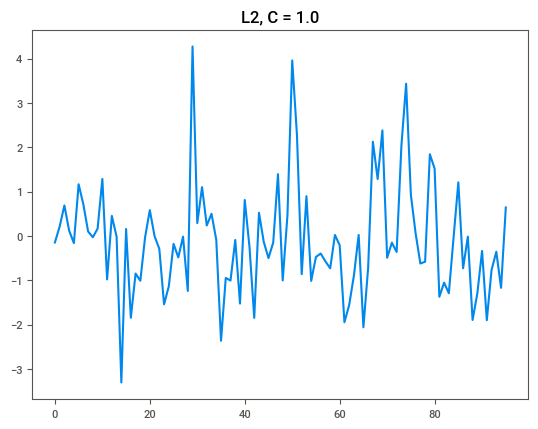

In [21]:
coef_plot(clf1, 'L2, C = 1.0')

#### The Summary
This logicstic model increases the accuracy compared to the null model. The accuracy is 97.3% on the training model and 97.1% on the test model. These are pretty close together, so there is no evidence of overfitting. The confusion matrix has the highest percentages on the downward angle which is good. The model is slightly better an predicting homes that are below $1 million, but that also comes from the fact that there are more houses in that bucket.

### Model 2
Same as Model 1, but use lasso regression instead of ridge regression. Create the same outputs and compare the performance to the ridge regression model.

#### The Model

In [22]:
# Create the Model
clf2_model = LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=2000)

#Normalization
clf2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf2_model)])
# Fit the Model
clf2.fit(X_train, y_train)

# Predict the Model
clf2.predict(X_test)

#Score the model
print(f'Training model: {clf2.score(X_train, y_train):.3f}')
print(f'Test model: {clf2.score(X_test, y_test):.3f}')

Training model: 0.974
Test model: 0.970


#### The Confusion Matrix

Confusion matrix on training data for L1 and C = 1.0
[[0.99100887 0.00899113]
 [0.26139295 0.73860705]]
Confusion matrix on testing data for L1 and C = 1.0
[[0.99123686 0.00876314]
 [0.28267477 0.71732523]]


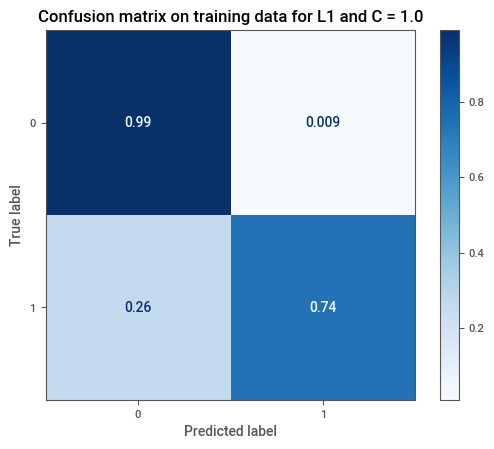

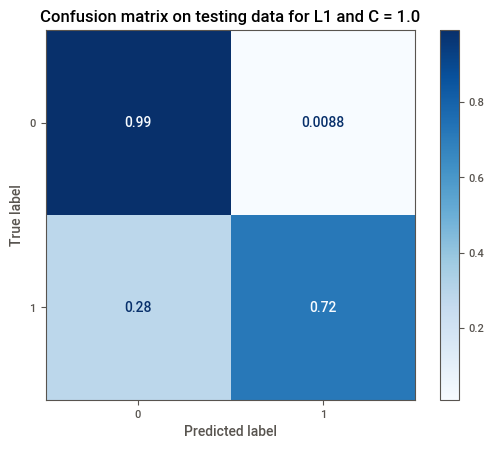

In [23]:
#Function defined in model 1
matrix2_options = [("Confusion matrix on training data for L1 and C = 1.0", 'true', X_train, y_train),
                  ("Confusion matrix on testing data for L1 and C = 1.0", 'true', X_test, y_test)]
con_matrix(clf2, matrix2_options)

#### The Coefficient Plot

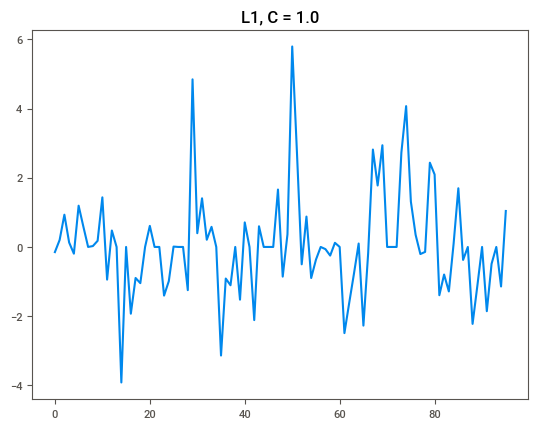

In [24]:
# Function defined above in model 1
coef_plot(clf2, 'L1, C = 1.0')

#### The Summary
The model with Lasso regression performs slightly better in accuracy than the ridge regression model. However, the different in the accuracy score, or percentage of correct predictions, only differs by 0.001, or 0.1%. This small of an advantage could be only a coincidence due to how the data split. I would need to do more cross validation to definatively show lasso regression is better. The confusion matrix on this model shows is it slightly better at predicting homes over a million and slightly worse at predicting home under that threshold. The differences from Model 1 continue to be minimal. The coefficient plot appears to be slightly more regular than the ridge regression in model 1, but there still is a lot of variability.

### Model 3
Fit another lasso regression but use `C=0.01`. Does this enforce more or less regularization? Create the same outputs and compare the performance to the first two models. Discuss why the plot looks so different than the previous plots.

#### The Model

In [25]:
# Create the Model
clf3_model = LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=2000)

#Normalization
clf3 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf3_model)])
# Fit the Model
clf3.fit(X_train, y_train)

# Predict the Model
clf3.predict(X_test)

#Score the model
print(f'Training model: {clf3.score(X_train, y_train):.3f}')
print(f'Test model: {clf3.score(X_test, y_test):.3f}')

Training model: 0.958
Test model: 0.957


C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


#### The Confusion Matrix

Confusion matrix on training data for L1 and C = 0.01
[[0.99262107 0.00737893]
 [0.52106621 0.47893379]]
Confusion matrix on testing data for L1 and C = 0.01
[[0.99223836 0.00776164]
 [0.47416413 0.52583587]]


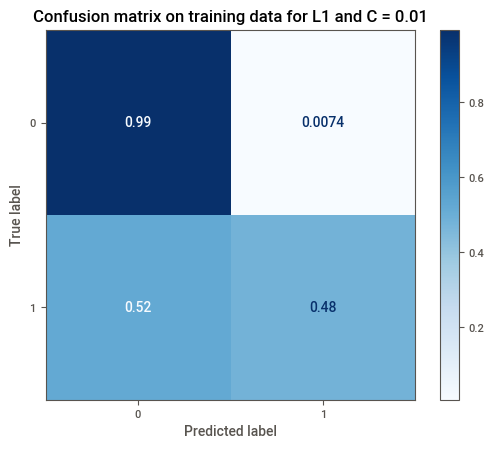

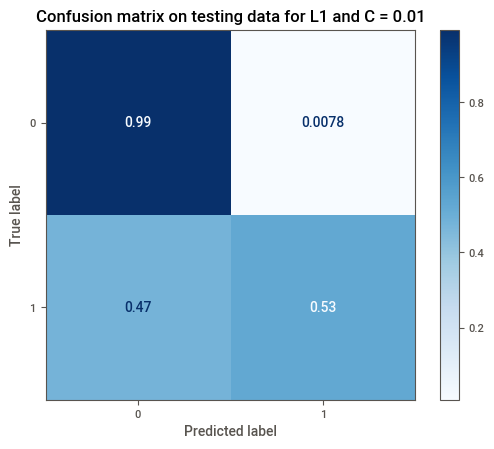

In [26]:
matrix3_options = [("Confusion matrix on training data for L1 and C = 0.01", 'true', X_train, y_train),
                  ("Confusion matrix on testing data for L1 and C = 0.01", 'true', X_test, y_test)]
con_matrix(clf3, matrix3_options)

#### The Coefficient Plot

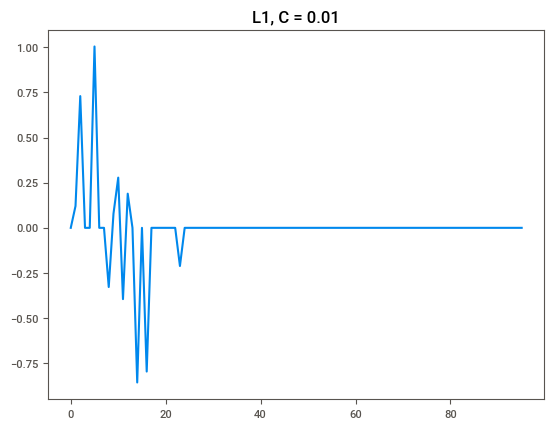

In [27]:
coef_plot(clf3, 'L1, C = 0.01')

#### The Summary
This model increases the regularization. Increasing the regularization, sacrifices some accuracy. However, the decrease is not drastic in this case. The accuracy score for the training data is 95.8% vs. 97.4% on the training data with `C = 1.0`. However, looking at the confusion matrix the model gets much worse at predicting houses that are greater than $1 million. At the higher C values, the false negatives, or Type 2 error, is 28% on the test data. With more regularization, the Type 2 error in model 3 increases to 47%. This graph look very different than the others because the regularization forces many coefficient in the model to 0. Only the 10ish most impactful coefficients still impact this model.

### Model 4
Now use `LogisticRegressionCV` to fit a model and let sklearn determine the optimal `C` value to use. Again, compute the accuracy score and confusion matrices. Also, print out the optimal value of `C`. Does regularization help for this problem?

#### The Model

##### Using `LogisticRegressionCV`

In [28]:
#Define the Cs to test
Cs = list(np.power(10.0, np.arange(-4, 5)))

# Create the Model
clf4_model = LogisticRegressionCV(penalty='l1', Cs = Cs, solver='saga', max_iter=100)

#Normalization
clf4 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf4_model)])
# Fit the Model
clf4.fit(X_train, y_train)

# Predict the Model
clf4.predict(X_test)

C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anacond

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
#Finding the best C value
avg_score = clf4['classifier'].scores_[1].mean(axis=0)

print(f"The best C value is {Cs[np.argmax(avg_score)]:.0f}.")

The best C value is 1000.


##### Using `GridSearchCV`

In [108]:
#Create the model
clf4b_model = LogisticRegression(penalty='l1', solver = 'saga')

#Create the grid search
gs4b = GridSearchCV(clf4b_model, param_grid = {'C': Cs, 'max_iter': [10, 50, 100, 500]})

#Create the pipeline
clf4b = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', gs4b)])
#Fit the model
clf4b.fit(X_train, y_train)

C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\Rachel K\anacond

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [114]:
print(f"The best C value is {clf4b['classifier'].best_params_['C']:.0f} for {clf4b['classifier'].best_params_['max_iter']:.0f} iterations.")
print(f"This combination has an accuracy score of {clf4b['classifier'].best_score_:.3f}.")

The best C value is 1 for 500 iterations.
This combination has an accuracy score of 0.972.


In [115]:
results = pd.DataFrame(clf4b['classifier'].cv_results_).sort_values(by = ['rank_test_score'])
results[['params', 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
23,"{'C': 10.0, 'max_iter': 500}",0.972412,1
19,"{'C': 1.0, 'max_iter': 500}",0.972412,1
27,"{'C': 100.0, 'max_iter': 500}",0.972354,3
35,"{'C': 10000.0, 'max_iter': 500}",0.972296,4
31,"{'C': 1000.0, 'max_iter': 500}",0.972296,4
30,"{'C': 1000.0, 'max_iter': 100}",0.969867,6
34,"{'C': 10000.0, 'max_iter': 100}",0.969809,7
26,"{'C': 100.0, 'max_iter': 100}",0.969751,8
22,"{'C': 10.0, 'max_iter': 100}",0.969751,8
18,"{'C': 1.0, 'max_iter': 100}",0.969289,10


##### The Best Model

In [47]:
#Create the model
clf4_best_model = LogisticRegression(penalty='l1', C = 1000, solver='saga', max_iter=2000)

#Normalization
clf4_best = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf4_best_model)])
# Fit the Model
clf4_best.fit(X_train, y_train)

# Predict the Model
clf4_best.predict(X_test)

#Score the model
print(f'Training model: {clf4_best.score(X_train, y_train):.3f}')
print(f'Test model: {clf4_best.score(X_test, y_test):.3f}')

Training model: 0.975
Test model: 0.972


C:\Users\Rachel K\anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


#### The Confusion Matrix

Confusion matrix on training data for L1 and C = 1000
[[0.99057481 0.00942519]
 [0.24505589 0.75494411]]
Confusion matrix on testing data for L1 and C = 1000
[[0.9907361  0.0092639 ]
 [0.26139818 0.73860182]]


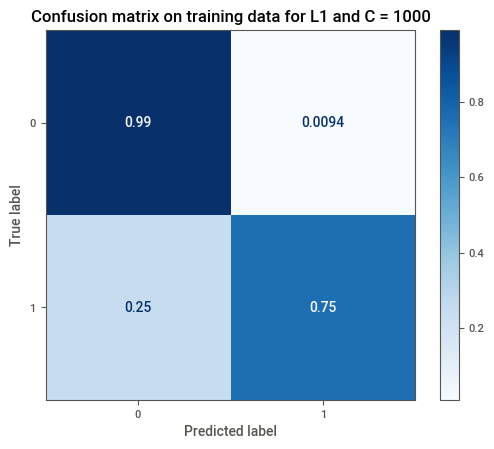

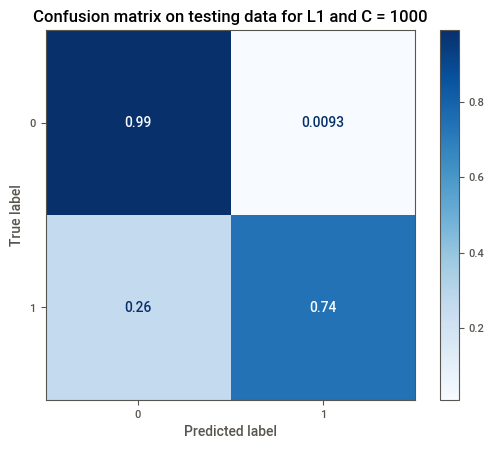

In [116]:
matrix4_best_options = [("Confusion matrix on training data for L1 and C = 1000", 'true', X_train, y_train),
                  ("Confusion matrix on testing data for L1 and C = 1000", 'true', X_test, y_test)]
con_matrix(clf4_best, matrix4_best_options)

#### The Coefficient Plot

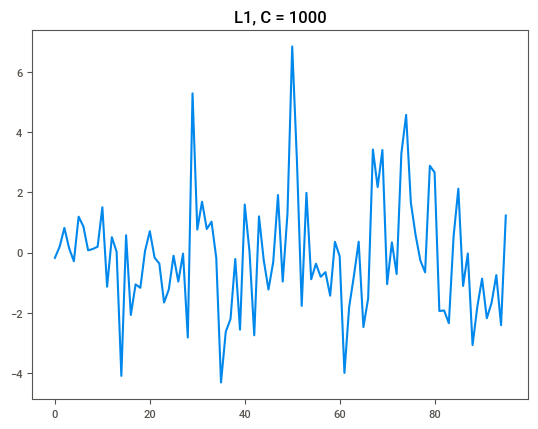

In [117]:
coef_plot(clf4_best, 'L1, C = 1000')

#### The Summary
 As you can see from the dataframe above. This model is very unstable. The best C value at 500 iteration is 10 or 1, while the best C value at 100 iterations is 10,000. This requires the analyst to make a decision. We cannot sit here all day running models and waiting for a convergence. The accuracy values for most models with a C greatere than 1 are very close. Some of the rankings even resulted in a tie. The overall trend shows that normalization is not espacially important to the model because the higher C values are prevailing. I am going to use the results from the original `LogisticRegressionCV()` for the confusion matrix and coefficient plot above, but the `GridSearchCV()` results also are a possible alternative. The cross validation provides the highest accuracy score so far in this assignment at 97.5% for the training and 97.2% in the test. The lack of a difference between the training and the test ensures that we are no overfitting the model despite the lack of normalization. The confusion matrix also has the lowest Type II error of any of the models we have seen so far.

### Task 5 - Simple decision tree
Now fit a decision tree to predict `price_gt_1M`. As we did above, for both train and test, compute the accuracy score, create a confusion matrix, and discuss the performance relative to your logistic regression models. Obviously you do not need to create a coefficient plot (why not?). 

#### The Model

In [27]:
# Create the model
clf5_model = DecisionTreeClassifier(random_state = 0)

# Create the pipline
clf5 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf5_model)])

#Fit the decision tree
clf5.fit(X_train, y_train)

#Predict on the decision tree
clf5.predict(X_test)

print(f"Training score: {clf5.score(X_train, y_train):.3f}")
print(f"Test score: {clf5.score(X_test, y_test):.3f}")

Training score: 1.000
Test score: 0.959


In [28]:
#Create the grid search
gs5 = GridSearchCV(clf5_model, param_grid = {'min_samples_split': [2, 5, 10, 15, 20, 100]})

#Create the pipeline
clf5b = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', gs5)])
#Fit the model
clf5b.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'grade',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated', 'lat',
                                                   'long', 'sqft_living15',
                                                   'sqft_lot15']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['waterfront', 'view',
                                                   'condition', 'zipcode'])])),
      

In [29]:
print(f"The best minimum node split is {clf5b['classifier'].best_params_['min_samples_split']:.0f}.")
print(f"This has an accuracy score of {clf5b['classifier'].best_score_:.3f}.")

The best minimum node split is 10.
This has an accuracy score of 0.961.


In [30]:
results = pd.DataFrame(clf5b['classifier'].cv_results_).sort_values(by = ['rank_test_score'])
results[['params', 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
2,{'min_samples_split': 10},0.961018,1
3,{'min_samples_split': 15},0.960729,2
4,{'min_samples_split': 20},0.960613,3
5,{'min_samples_split': 100},0.959977,4
1,{'min_samples_split': 5},0.959630,5
0,{'min_samples_split': 2},0.959225,6


In [31]:
# Create the model
clf5_best_model = DecisionTreeClassifier(random_state = 0, min_samples_split = 10)

# Create the pipline
clf5_best = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf5_best_model)])

#Fit the decision tree
clf5_best.fit(X_train, y_train)

#Predict on the decision tree
clf5_best.predict(X_test)

print(f"Training score: {clf5_best.score(X_train, y_train):.3f}")
print(f"Test score: {clf5_best.score(X_test, y_test):.3f}")

Training score: 0.991
Test score: 0.960


#### The Confusion Matrix

Confusion matrix on training data for decision tree with min nodes of 10
[[0.99658957 0.00341043]
 [0.09372313 0.90627687]]
Confusion matrix on testing data for decision tree with min nodes of 10
[[0.98172258 0.01827742]
 [0.3100304  0.6899696 ]]


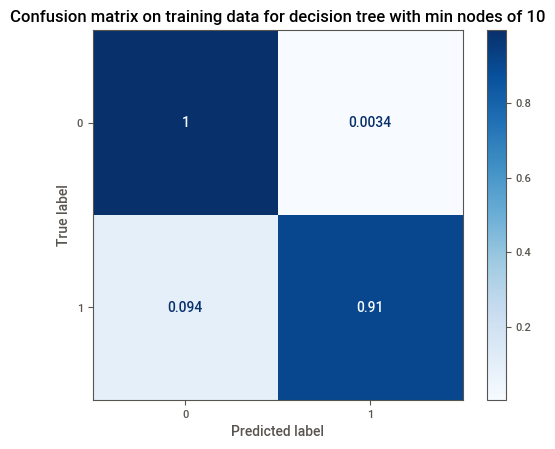

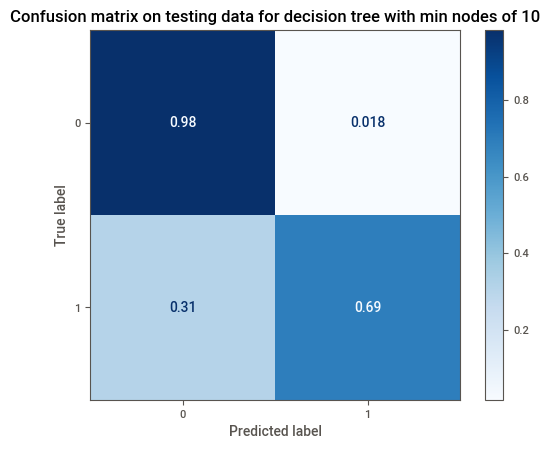

In [32]:
matrix5_best_options = [("Confusion matrix on training data for decision tree with min nodes of 10", 'true', X_train, y_train),
                  ("Confusion matrix on testing data for decision tree with min nodes of 10", 'true', X_test, y_test)]
con_matrix(clf5_best, matrix5_best_options)

#### Viewing the Tree - Hacker Extra Credit

In [53]:
def visualize_tree(tree, feature_names, dot_filename, png_filename):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecisionTree.
    feature_names -- list of feature names.
    """
    with open(dot_filename, 'w+') as f:
        export_graphviz(tree, out_file=f,
                       feature_names = feature_names)

    command = ["dot", "-Tpng", dot_filename, "-o", png_filename]
    try:
        subprocess.run(args=command, shell=True, check=True)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [54]:
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
visualize_tree(clf5_best['classifier'], feature_names, "output/dt.dot", "output/dt.png")

In [55]:
Image("output/dt.png")